In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time


In [2]:
# Read in the saved camera matrix and distortion coefficients
# Calculated in camera_calibration.py
dist_pickle = pickle.load(open("camera_cal/camera_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [3]:
src=np.float32([(240,695),(595,450),(1070,695),(685,450)])
dest=np.float32([(400,720),(400,50),(800,720),(800,50)])



def warp(img):
    #undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    M = cv2.getPerspectiveTransform(src, dest)
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img):
    M = cv2.getPerspectiveTransform(dest, src)
    unwarped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return unwarped

In [4]:
def binarize(img, s_thresh=(130, 255), sx_thresh=(15, 135)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [16]:
def top_view_binarized(img):
    undistorted = undistort(img)
    binarized = binarize(undistorted)
    return warp(binarized)

In [6]:
def lanes_from_windows(img,draw_windows=False):
    # Take a histogram of the bottom half of the binary top-view image
    histogram = np.sum(img[img.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    quarter_width = np.int(histogram.shape[0] /4)
    leftx_base = np.argmax(histogram[quarter_width:2*quarter_width])
    rightx_base = np.argmax(histogram[2*quarter_width:3*quarter_width]) + 2*quarter_width
    leftx_base = np.argmax(histogram[360:480]) + 360
    rightx_base = np.argmax(histogram[780:900]) + 780
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                      (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                      (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if draw_windows:
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    return left_fit, right_fit

In [7]:
def lanes_from_previous(img, left_fit, right_fit, draw_lanes=False):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if draw_lanes:
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img)) * 255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin,
                                                                        ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin,
                                                                         ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()

    return left_fit, right_fit

In [8]:
def draw_lane(img,left_fit,right_fit):
    lane_img = np.zeros_like(img)
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    left_line_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_line_points, right_line_points))
    cv2.fillPoly(lane_img, np.int_([lane_pts]), (0,255,0))
    lane_img=unwarp(lane_img)
    composite=cv2.addWeighted(img,1,lane_img,0.3,0)
    return composite
    

In [9]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def estimate_curvature(left_fit,right_fit,y_eval):
    scaled_a_left=xm_per_pix / (ym_per_pix ** 2) * left_fit[0]
    scaled_b_left=xm_per_pix / ym_per_pix * left_fit[1]
    scaled_a_right=xm_per_pix / (ym_per_pix ** 2) * right_fit[0]
    scaled_b_right=xm_per_pix / ym_per_pix * right_fit[1]

    #y_eval = 720
    left_curverad = ((1 + (2*scaled_a_left*y_eval + scaled_b_left)**2)**1.5) / np.absolute(2*scaled_a_left)
    right_curverad = ((1 + (2*scaled_a_right*y_eval + scaled_b_right)**2)**1.5) / np.absolute(2*scaled_a_right)
    return left_curverad, right_curverad



720
1876.05244497 1822.76221968


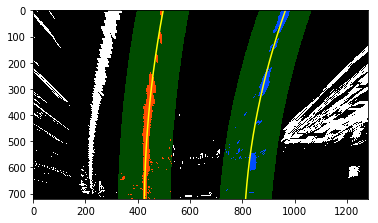

(array([  1.23346696e-04,  -1.88004501e-01,   4.97258440e+02]),
 array([  1.93153925e-04,  -3.50094632e-01,   9.64596847e+02]))

In [27]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/test4.jpg')
binary_top_view = top_view_binarized(img)
left_fit,right_fit = lanes_from_windows(binary_top_view)
left_curverad, right_curverad = estimate_curvature(left_fit, right_fit, y_eval=img.shape[0])
print(img.shape[0])
print(left_curverad, right_curverad)

lanes_from_previous(binary_top_view,left_fit,right_fit,draw_lanes=True)

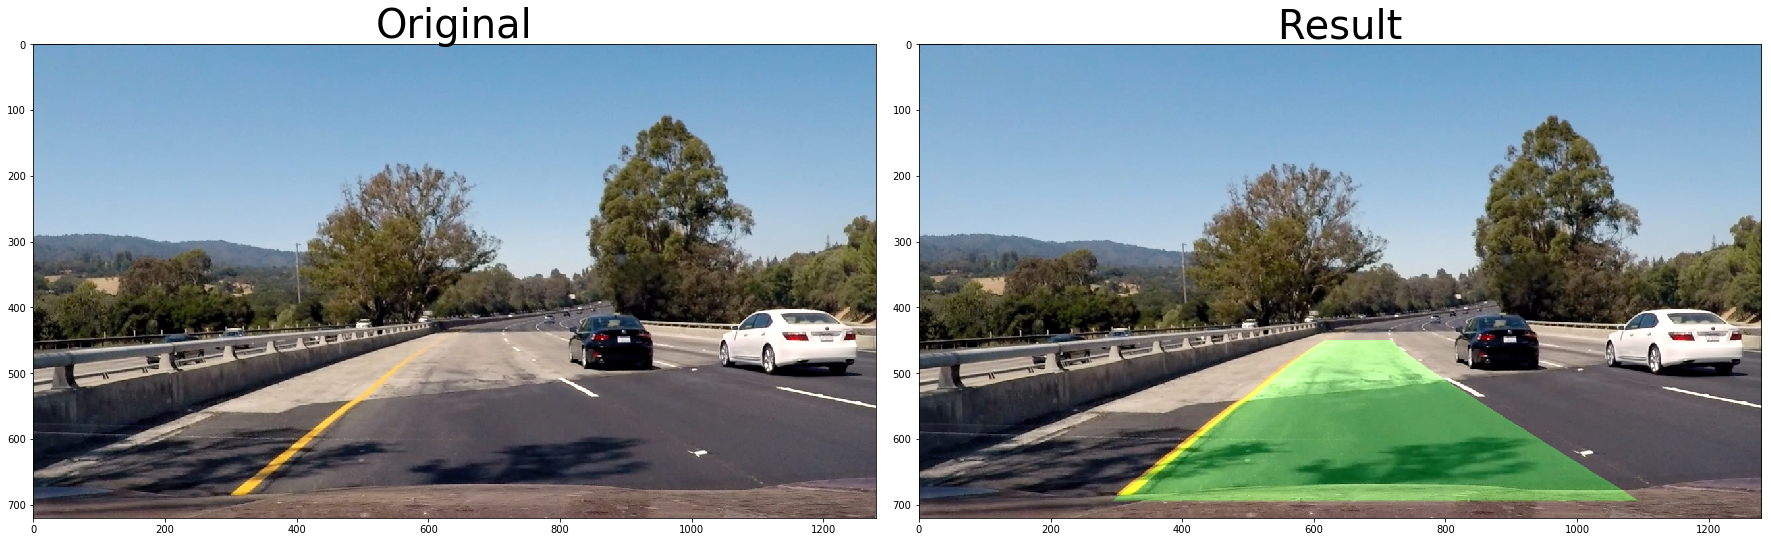

In [29]:
show_two(img,process_image(img))

In [22]:
left_fit = None
right_fit = None
def find_lane_lines(img,left_fit,right_fit):
    if left_fit is None:
        left_fit,right_fit = lanes_from_windows(img)
    else:
        left_fit,right_fit = lanes_from_previous(img,left_fit,right_fit)
    return left_fit, right_fit

In [20]:
def process_image(img):
    global left_fit, right_fit
    binary_top_view = top_view_binarized(img)
    left_fit, right_fit = find_lane_lines(binary_top_view,left_fit,right_fit)
    return draw_lane(img,left_fit,right_fit)
    
    

In [31]:
output_video = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file output_videos/project_video.mp4:

 b"Unrecognized option 'preset'.\nError splitting the argument list: Option not found\n"

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

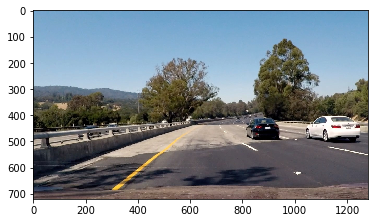

In [21]:
img = cv2.imread('test_images/test4.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
def show_two(img,img2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original', fontsize=40)

    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax2.set_title('Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

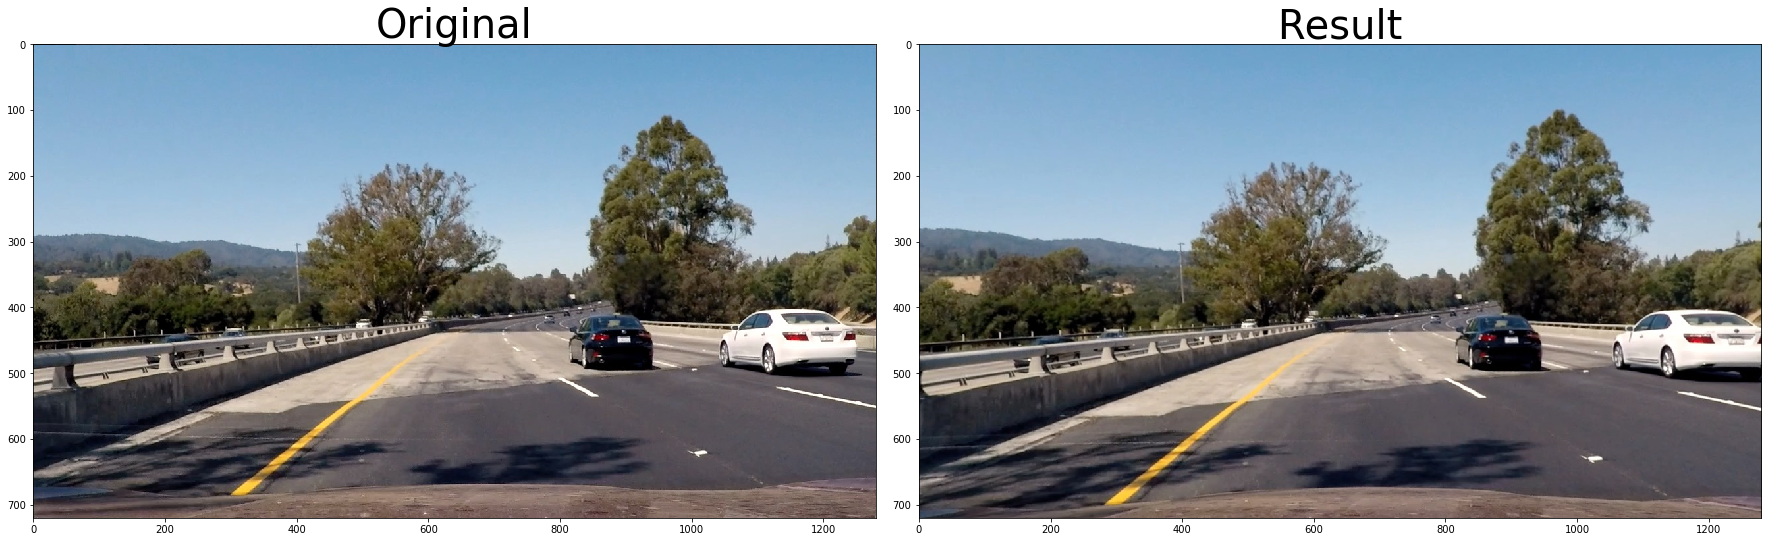

In [24]:
show_two(img,undistort(img))

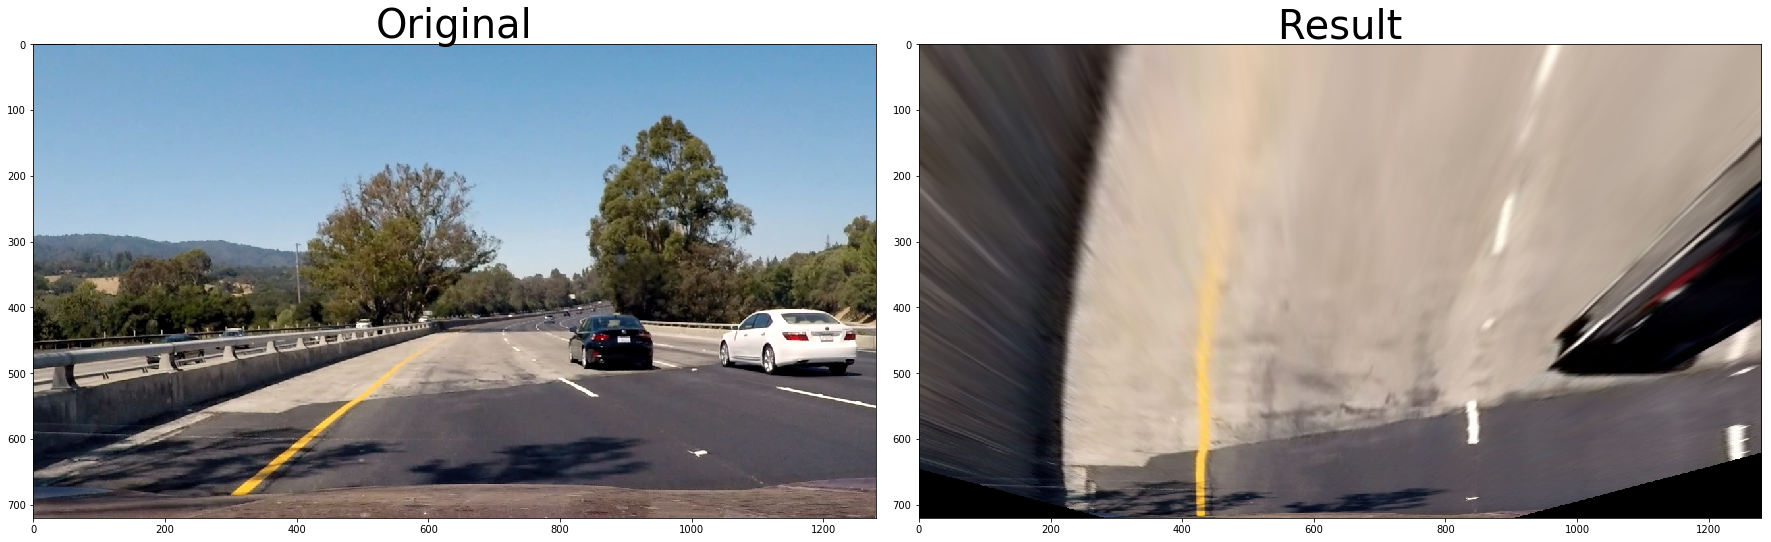

In [37]:
show_two(img,warp(img))

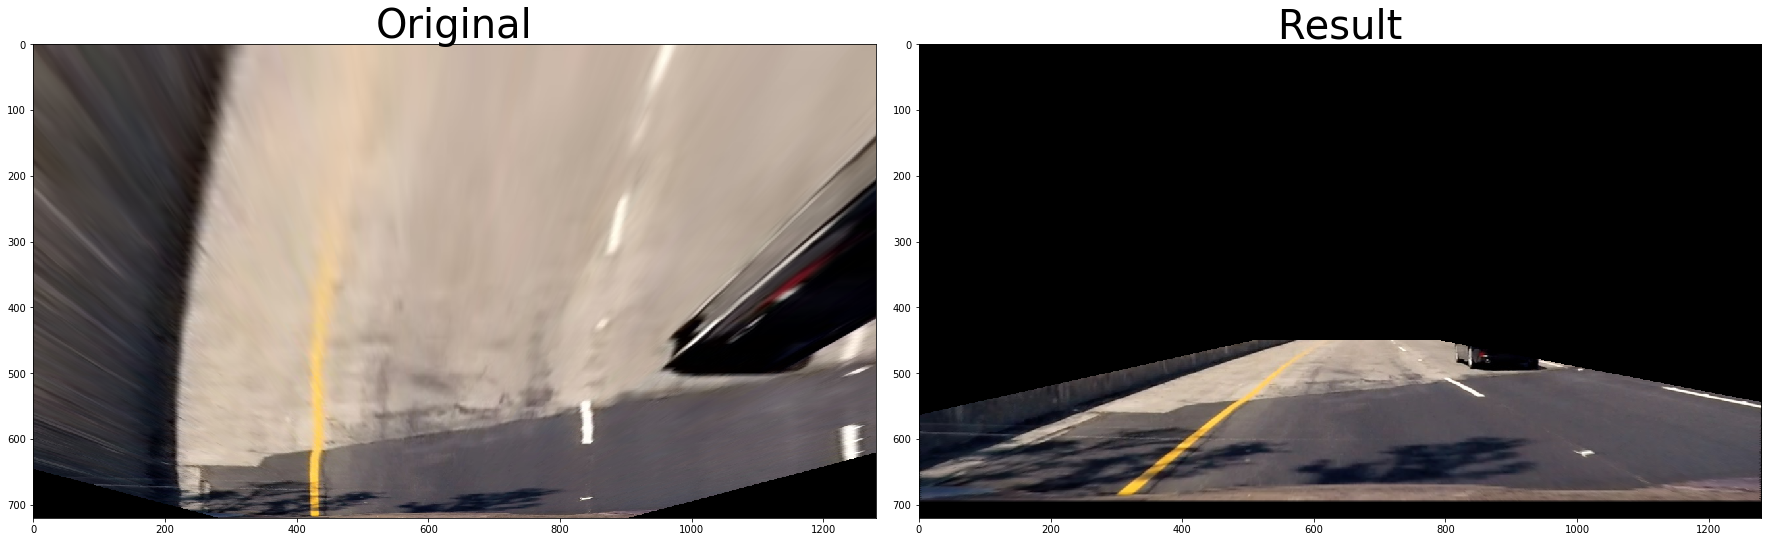

In [38]:
show_two(warp(img),unwarp(warp(img)))

In [27]:
def distort(img):
    return cv2.undistort(img, dist, mtx, None, mtx)

In [28]:
show_two(img,distort(undistort(img)))

error: /opt/concourse/worker/volumes/live/68762549-a7cd-401a-4fc4-6547354af396/volume/opencv_1512680491081/work/modules/imgproc/src/undistort.cpp:103: error: (-215) A.size() == Size(3,3) && A.size() == R.size() in function initUndistortRectifyMap
